In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/MyDrive/Colab_Notebooks/DL

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/DL


#Import packages

In [ ]:
!pip install transformers==3.5.1
!pip install torch==1.4.0
!pip install contractions
!pip install pyspellchecker
!pip install wordsegment
! pip install umap-learn

In [ ]:
import random
import warnings
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import nltk
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet,words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk_words =  set.union(set(words.words()), set(wordnet.all_lemma_names()))
nltk_words_lower = [word.lower() for word in nltk_words ]

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF,PCA, TruncatedSVD
from sklearn.metrics import f1_score, accuracy_score
from sklearn.manifold import TSNE
import umap

from spellchecker import SpellChecker
spell = SpellChecker()
import contractions
from wordsegment import load, segment
load()

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Data loading

In [26]:
data = pd.read_csv('Dataset/train.csv')

# Data cleaning

In [27]:
# Leave only text and target columns
data = data[['target','text']]
print(data.shape)
print('Number of disaster tweets: ',len(data[data['target']==1]))
print('Number of non-disaster tweets: ',len(data[data['target']==0]))
display(data.sample(3))

(7613, 2)
Number of disaster tweets:  3271
Number of non-disaster tweets:  4342


,target,text
7138,1,@MrMikeEaton @Muazimus_Prime hill hill mountai...
2151,1,Cancers equate for around 25% of all deaths in...
4395,1,The Murderous Story Of AmericaÛªs First Hijac...


In [28]:
# Remove unwanted characters: punctuations, urls, emojis etc

def clean_text(text):

    # remove url
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'', text)
    text = re.sub(r'bit.ly/\S+', '', text) # rempve bitly links
    text = text.strip('[link]') # remove [links]

    # remove emoji
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    
    # remove html
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    text = re.sub(html, '', text)

    # remove retweet
    text = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) 
    
    # remove tweeted at
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) 

    # remove double spacing, numbers,lowercase
    text = text.lower()
    text = re.sub('\s+', ' ', text) #remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers

    # remove contractions
    expanded_words = []
    for word in text.split():
        expanded_words.append(contractions.fix(word))
    text = ' '.join(expanded_words)

    # remove punctuation
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)

    my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@#ûó'
    text = re.sub('['+my_punctuation + ']+', ' ', text) # strip punctuation

    # create token list
    text_token_list = [word for word in text.strip().split(' ')]

    #remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    f = open('./Dataset/stopwords.txt') ; my_stopwords = set(f.read().split('\n')) ; f.close()
    stopwords = list(set(stopwords).union(my_stopwords))
    text_token_list = [word for word in text_token_list if word not in stopwords]

    # change to str
    text = ' '.join(list(text_token_list))

    return text

In [29]:
def split_words(text):

  words = text.split()
  for i,word in enumerate(words):
    if word not in nltk_words_lower:
        if len(segment(word))!=0:
            words[i] = segment(word)[0]

  text = ' '.join(words)
  return text


def spell_words(text):

  words = text.split()
  for i,word in enumerate(words):
    if word not in nltk_words_lower:
        words[i] = spell.correction(words[i])
  
  text = ' '.join(words)
  return text

In [30]:
file=open("Dataset/slang.txt","r")
slang=file.read()

def remove_slang(slang, text):
    # remove slang
    corpus = text.split()
    #separating each line present in the file
    slang=slang.split('\n')
    
    slang_word=[]
    meaning=[]
    
    #store the slang words and meanings in different lists
    for line in slang:
        temp=line.split("=")
        slang_word.append(temp[0])
        meaning.append(temp[-1])
    
    #replace the slang word with meaning
    for i,word in enumerate(corpus):
        if word in slang_word:
            idx=slang_word.index(word)
            # print(word,meaning[idx])
            corpus[i]=meaning[idx]
    corpus = ' '.join(corpus)
    return corpus

In [31]:
start = time.time()

data['text_clean'] = data['text'].apply(lambda x: clean_text(x))

end = time.time()
print(end - start,'sec')

12.744172811508179 sec


In [32]:
start = time.time()

data['text_clean'] = data['text_clean'].apply(lambda x: split_words(x))

end = time.time()
print(end - start,'sec')

250.57087922096252 sec


In [33]:
start = time.time()

data['text_clean'] = data['text_clean'].apply(lambda x: spell_words(x))

end = time.time()
print(end - start,'sec')

367.0904395580292 sec


In [34]:
start = time.time()

data['text_clean'] = data['text_clean'].apply(lambda x: remove_slang(slang,x))

end = time.time()
print(end - start,'sec')

0.3612508773803711 sec


In [35]:
# Get the tokens
data['tokenized'] = data['text_clean'].apply(word_tokenize)
data.head()

,target,text,text_clean,tokenized
0,1,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake allah forgive,"[deeds, reason, earthquake, allah, forgive]"
1,1,Forest fire near La Ronge Sask. Canada,forest fire la range ask canada,"[forest, fire, la, range, ask, canada]"
2,1,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...,"[residents, asked, shelter, place, notified, o..."
3,1,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...,"[people, receive, wildfires, evacuation, order..."
4,1,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [36]:
# Get part of speech for a word
data['tags'] = data['tokenized'].apply(nltk.tag.pos_tag)
data.head()

,target,text,text_clean,tokenized,tags
0,1,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake allah forgive,"[deeds, reason, earthquake, allah, forgive]","[(deeds, NNS), (reason, NN), (earthquake, NN),..."
1,1,Forest fire near La Ronge Sask. Canada,forest fire la range ask canada,"[forest, fire, la, range, ask, canada]","[(forest, JJS), (fire, NN), (la, NN), (range, ..."
2,1,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...,"[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)..."
3,1,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...,"[people, receive, wildfires, evacuation, order...","[(people, NNS), (receive, VBP), (wildfires, NN..."
4,1,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N..."


In [37]:
# Convert to wordnet format.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

data['tags'] = data['tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
data.head()

,target,text,text_clean,tokenized,tags
0,1,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake allah forgive,"[deeds, reason, earthquake, allah, forgive]","[(deeds, n), (reason, n), (earthquake, n), (al..."
1,1,Forest fire near La Ronge Sask. Canada,forest fire la range ask canada,"[forest, fire, la, range, ask, canada]","[(forest, a), (fire, n), (la, n), (range, n), ..."
2,1,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...,"[residents, asked, shelter, place, notified, o...","[(residents, n), (asked, v), (shelter, a), (pl..."
3,1,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...,"[people, receive, wildfires, evacuation, order...","[(people, n), (receive, v), (wildfires, n), (e..."
4,1,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, v), (sent, a), (photo, n), (ruby, n), (..."


In [38]:
# Lemmatize
wnl = WordNetLemmatizer()
data['lemmatized'] = data['tags'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
data['lemmatized'] = data['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])
data['text_final'] = [' '.join(map(str, l)) for l in data['lemmatized']]
data.head()

,target,text,text_clean,tokenized,tags,lemmatized,text_final
0,1,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake allah forgive,"[deeds, reason, earthquake, allah, forgive]","[(deeds, n), (reason, n), (earthquake, n), (al...","[deed, reason, earthquake, allah, forgive]",deed reason earthquake allah forgive
1,1,Forest fire near La Ronge Sask. Canada,forest fire la range ask canada,"[forest, fire, la, range, ask, canada]","[(forest, a), (fire, n), (la, n), (range, n), ...","[forest, fire, la, range, ask, canada]",forest fire la range ask canada
2,1,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...,"[residents, asked, shelter, place, notified, o...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,1,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...,"[people, receive, wildfires, evacuation, order...","[(people, n), (receive, v), (wildfires, n), (e...","[people, receive, wildfire, evacuation, order,...",people receive wildfire evacuation order calif...
4,1,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfires pou...


In [ ]:
# show words not in dict
def show_non_correct_words(text):
  words = text.split()
  for i,word in enumerate(words):
    if word not in nltk_words_lower:
      print(word)

data['text_final'].apply(lambda x: show_non_correct_words(x))

# Data visualization

plot most common words, bigrams and trigrams

In [44]:
targets = [data[data['target'] == 0]['text_final'] , data[data['target'] == 1]['text_final']]
sns.set(rc={"figure.dpi":600, 'savefig.dpi':600})
def plot_ngrams(n, number_of_ngrams = 20):
    """A Function to plot most common ngrams"""

    def get_ngram(corpus, n=None):
      # Get the most common ngrams
      vec = CountVectorizer(ngram_range=(n, n),
                            max_df=0.9,
                            stop_words='english').fit(corpus)
      bag_of_words = vec.transform(corpus)
      sum_words = bag_of_words.sum(axis=0)
      words_freq = [(word, sum_words[0, idx])
                    for word, idx in vec.vocabulary_.items()]
      words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
      return words_freq[:number_of_ngrams]

    sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})   

    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    axes = axes.flatten()
    for text, ax in zip(targets, axes):

        # Split each sequence and put it into a list. Put all words into a list
        tokens = text.str.split()
        tokens = tokens.values.tolist()
        corpus = [word for text in tokens for word in text]

        top_n_bigrams = get_ngram(text, n)
        y, x = map(list, zip(*top_n_bigrams))
        sns.barplot(x=x, y=y, palette='crest', ax=ax)
        
        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Frequency')
        axes[0].set_ylabel(str(n)+'-grams')
        axes[1].set_xlabel('Frequency')
        axes[1].set_ylabel(str(n)+'-grams')
        fig.suptitle('Most Common n-grams, n='+str(n), va='baseline')
        plt.tight_layout()
        # plt.ylim(0,.02)

In [45]:
[plot_ngrams(i, number_of_ngrams = 20) for i in range(1,4)]

Output hidden; open in https://colab.research.google.com to view.

# Embeddings

-  There are 15928 unique words adn 7613 tweets. At the beginning, we obtain, in different ways with countvectorizer or tfidf, different forms to obtain for each tweet. For countvect,we have an array of size 15928 where there are 1 when that word is present and 0 otherwise. Therefore, we have a matrix of 7613x15928
We can apply TruncatedSVD for example and reduce it to 2 components

- For glovo, the points is that I get vector representation not for each tweet but for each word.  when apply it we obtain a vector of 100D representation for each word, and since there are 15928 unique words, we get 15928x100 matrix. At the same time, we also wet an matrix in which each tweet is represented by the words of the id's

In [73]:
X = data['text_final'].tolist()
Y = data['target'].tolist()

In [74]:
sns.set(rc={"figure.dpi":80, 'savefig.dpi':80})
def plot_sns(X,Y='None'):
    sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})   
    if Y=='None':
        g = sns.scatterplot(x=X[:,0], y=X[:,1],linewidth=0.1, legend=True,s=20,alpha=1)
    else:
        g = sns.scatterplot(x=X[:,0], y=X[:,1],hue=Y,palette=["b", "r"],linewidth=0.1, legend=True,s=20,alpha=1)
    g.legend(['Non disaster tweets', 'Disaster tweets'])
    sns.move_legend(g, "upper right")
    # plt.ylim(0,.02)
    plt.show(g)
    
def plot_dim_reduction(X,Y, sklearn_dec):
    sklearn_dec.fit(X)
    decomposition = sklearn_dec.transform(X)
    plot_sns(decomposition,Y=Y)

## CountVectorizer

In [75]:
''' CountVectorizer:
emb is a matrix that has shape (7613, 15689). There are 15689 unique words. For each tweet, there is a 1 where the word appers and a 0 where not.
# this is compactly represented in a sparse matrix, where for each tweet, there's for each word its id '''
ngram = 1 # Can also try with bigrams and trigrams
count_vectorizer = CountVectorizer(ngram_range = (ngram, ngram))
emb = count_vectorizer.fit_transform(X)

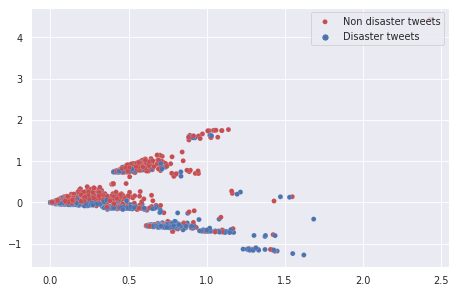

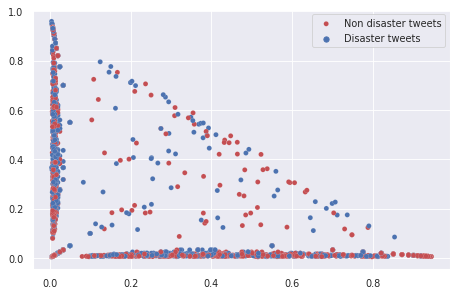

In [76]:
plot_dim_reduction(emb, Y, TruncatedSVD(n_components=2))
plot_dim_reduction(emb, Y, LatentDirichletAllocation())

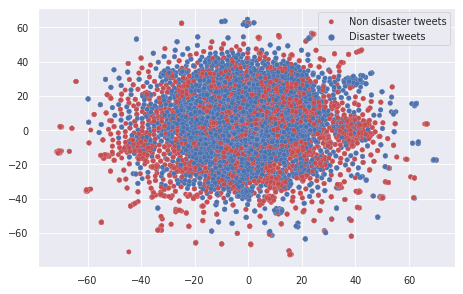

In [77]:
decomposition = TSNE(n_components=2, verbose=0, learning_rate='auto', init='random').fit_transform(emb)
plot_sns(decomposition,Y)

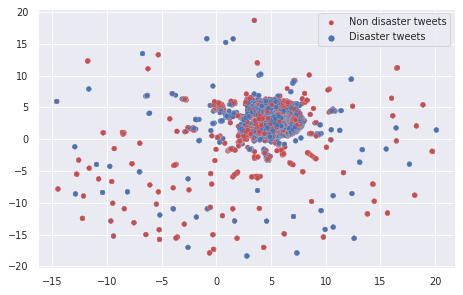

In [78]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(emb)
plot_sns(trans.embedding_,Y)

## TfidfVectorizer

In [79]:
# TfidfVectorizer
ngram = 1 # try with bigrams and trigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range = (ngram, ngram))
emb = tfidf_vectorizer.fit_transform(X)

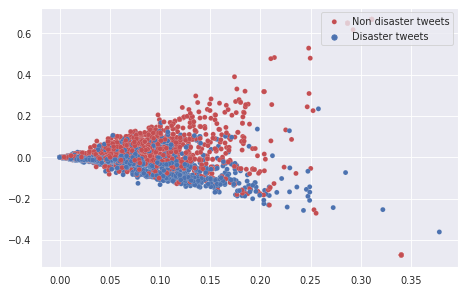

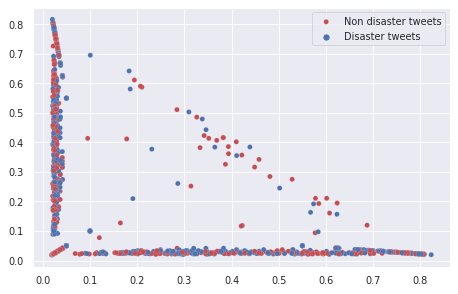

In [80]:
plot_dim_reduction(emb, Y, TruncatedSVD(n_components=2))
plot_dim_reduction(emb, Y, LatentDirichletAllocation())

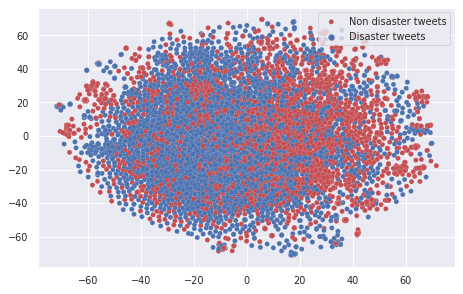

In [81]:
decomposition = TSNE(n_components=2, verbose=0, learning_rate='auto', init='random').fit_transform(emb)
plot_sns(decomposition,Y)

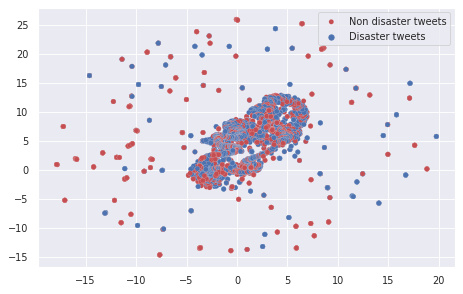

In [82]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(emb)
plot_sns(trans.embedding_,Y)

## TfidfVectorizer 2gram

In [83]:
# TfidfVectorizer
ngram = 2 # try with bigrams and trigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range = (ngram, ngram))
emb = tfidf_vectorizer.fit_transform(X)

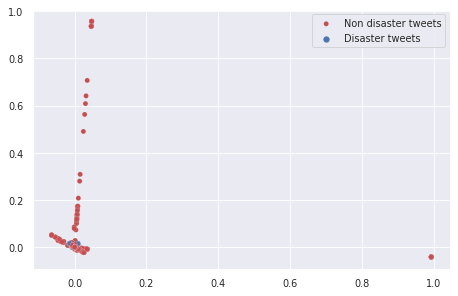

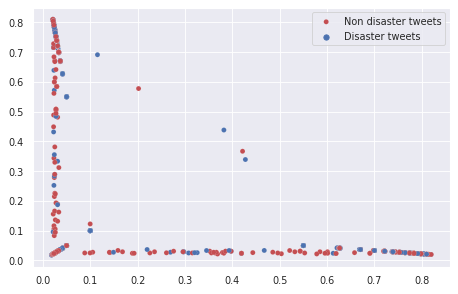

In [84]:
plot_dim_reduction(emb, Y, TruncatedSVD(n_components=2))
plot_dim_reduction(emb, Y, LatentDirichletAllocation())

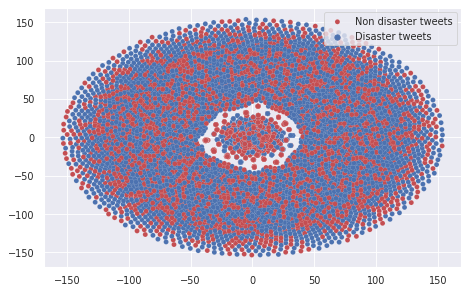

In [85]:
decomposition = TSNE(n_components=2, verbose=0, learning_rate='auto', init='random').fit_transform(emb)
plot_sns(decomposition,Y)

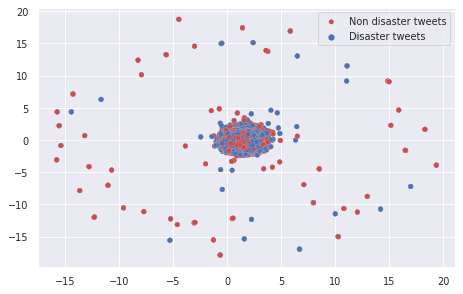

In [86]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(emb)
plot_sns(trans.embedding_,Y)

## TfidfVectorizer 3gram

In [87]:
# TfidfVectorizer
ngram = 3 # try with bigrams and trigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range = (ngram, ngram))
emb = tfidf_vectorizer.fit_transform(X)

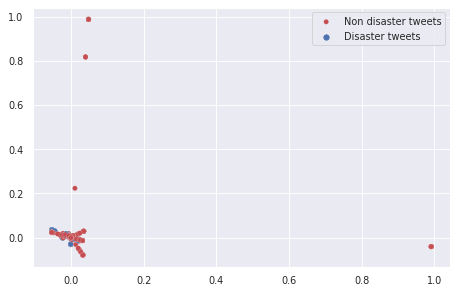

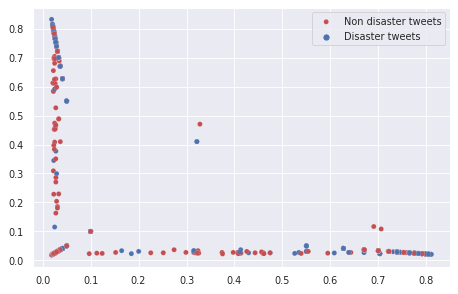

In [88]:
plot_dim_reduction(emb, Y, TruncatedSVD(n_components=2))
plot_dim_reduction(emb, Y, LatentDirichletAllocation())

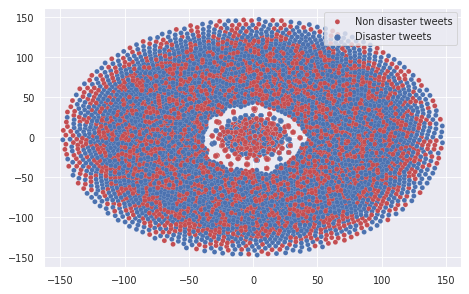

In [89]:
decomposition = TSNE(n_components=2, verbose=0, learning_rate='auto', init='random').fit_transform(emb)
plot_sns(decomposition,Y)

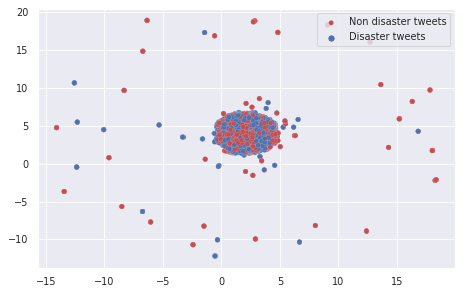

In [90]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(emb)
plot_sns(trans.embedding_,Y)

## GloVe

In [91]:
# GloVe
# Here we will use GloVe pretrained corpus model to represent our words. It is available in 3 varieties : 50D, 100D and 200 Dimentional. We will try 100D here.
corpus = [i.split() for i in data['text_final']]

In [92]:
# Read the words and their embeddings and put them in a dictionary
embedding_dict={}
with open('./Dataset/GloVe/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [93]:
# Once we have the corpus (the text itself), we represent it with the id's of the words and we padd the sentences

MAX_LEN=85 # len of the longest seq
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

corpus_padded=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [94]:
# The corpus_padded has 7613 elements (tweets) and 50 characters per tweet. Each word is expressed in its ID
print(corpus_padded.shape)
print(corpus_padded[0])

(7613, 85)
[3503  511  173 1181 2758    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [95]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 9654


In [96]:
# For each word, get the embedding in the 15928 unique words, get the embedding of 100 dim for each word
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))
c = 0
b = 0
wrong_words = []
for word,i in word_index.items():
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            b += 1
            embedding_matrix[i]=emb_vec 
        else:
            c +=1
            wrong_words.append(word)
print(c,'words dont appear in the corpus and',b,'appear')

175 words dont appear in the corpus and 9479 appear


In [97]:
print(embedding_matrix.shape)
print(corpus_padded.shape)

(9655, 100)
(7613, 85)


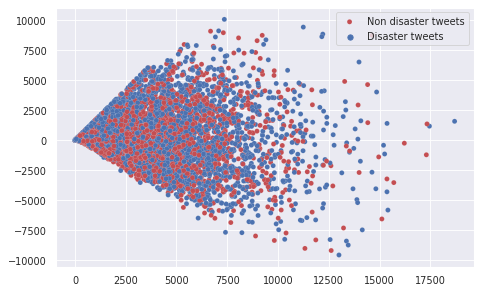

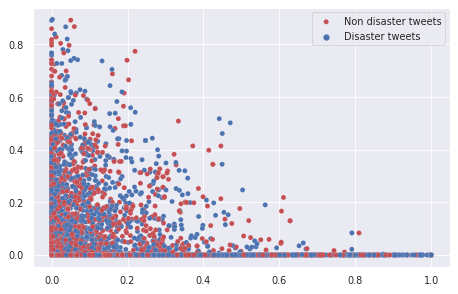

In [98]:
plot_dim_reduction(corpus_padded, Y, TruncatedSVD(n_components=2))
plot_dim_reduction(corpus_padded, Y, LatentDirichletAllocation())

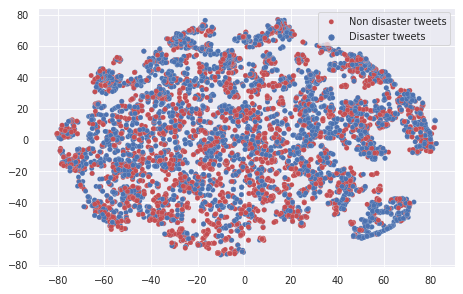

In [99]:
decomposition = TSNE(n_components=2, verbose=0, learning_rate='auto', init='random').fit_transform(corpus_padded)
plot_sns(decomposition,Y)

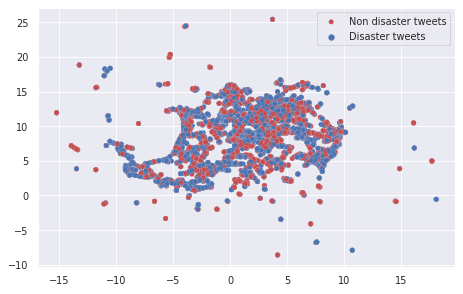

In [100]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(corpus_padded)
plot_sns(trans.embedding_,Y)

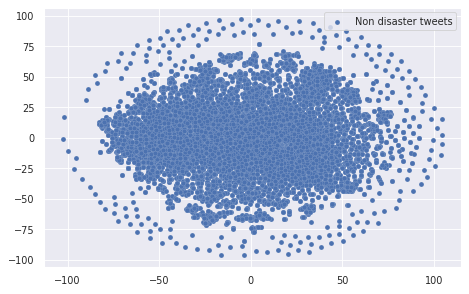

In [101]:
decomposition = TSNE(n_components=2, verbose=0, learning_rate='auto', init='random').fit_transform(embedding_matrix)
plot_sns(decomposition)

# BERT

Steps:

- Tokenize all the text with BertTokenizer (check max len of tweets)

- Get tokens and masks from BertTokenizer. Put the data into Tensor dataset (input_ids, attention_masks, labels)

- Divide in train and validation. Create a DataLoader for each

-

In [103]:
data = pd.read_csv('Dataset/train.csv')
pred = pd.read_csv('Dataset/test.csv')
print(f'Number of labelled tweets: {data.shape[0]}\n')
display(data.sample(3))

Number of labelled tweets: 7613



,id,keyword,location,text,target
795,1153,blight,NaN,http://t.co/ETkd58Un8n - Cleveland Heights Sha...,0
4362,6197,hijacker,Washington state,Governor Allows Parole for School Bus Hijacker...,1
6597,9449,terrorism,NaN,Truth...\nhttps://t.co/nXS3Z1kxiD\n#News\n#BBC...,1


In [104]:
# Get the text from the df and the index to later divide it between train and test
labels = data['target'].values
idx = len(labels)
combined = pd.concat([data, pred])
combined = combined.text.values

In [105]:
# Get tokens using BertTokenizer. It does a mapping from the words to their IDs and 
# does padding or truncating depending on len_max. A mask is added, with 1's or 0's to
# distinguish between [PAD] tokens and the rest of the tokens.  
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [106]:
print('Original: ', combined[12])
# Tokenizes sequences
print('Tokenized: ', tokenizer.tokenize(combined[12]))
# ID's for each sentence
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

Original:  #raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count 
Tokenized:  ['#', 'raining', '#', 'flooding', '#', 'florida', '#', 'tampa', '##bay', '#', 'tampa', '18', 'or', '19', 'days', '.', 'i', "'", 've', 'lost', 'count']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


In [108]:
data= combined[:idx]
pred = combined[idx:]
data.shape

(7613,)

In [109]:
def tokenize_map(sentence,labs='None'):
    
    """A function for tokenize all of the sentences and map the tokens to their word IDs."""
    
    global labels
    
    input_ids = []
    attention_masks = []

    # For every sentence...
    
    for text in sentence:
        #   "encode_plus" will:
        
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 84,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list. 
        
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

In [110]:
# Tokenize the sentences and get their IDs 
input_ids, attention_masks, labels = tokenize_map(data, labels)

In [112]:
input_ids.numpy().shape

(7613, 84)

In [113]:
labels.numpy().shape

(7613,)

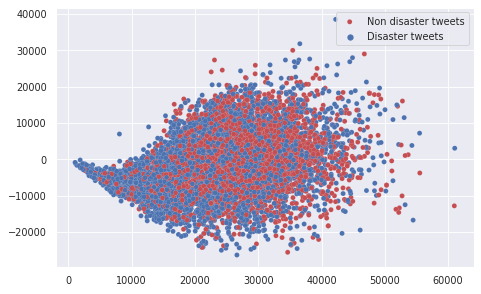

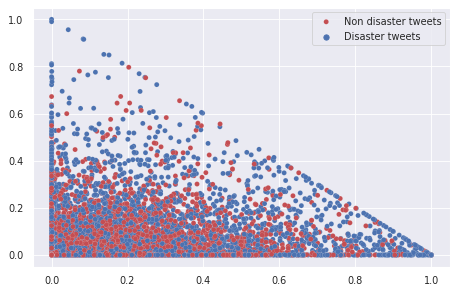

In [114]:
plot_dim_reduction(input_ids.numpy(), labels.numpy(), TruncatedSVD(n_components=2))
plot_dim_reduction(input_ids.numpy(),labels.numpy(), LatentDirichletAllocation())

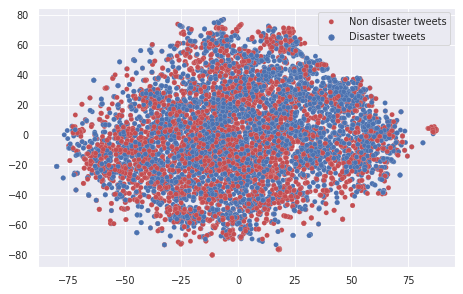

In [115]:
decomposition = TSNE(n_components=2, verbose=0, learning_rate='auto', init='random').fit_transform(input_ids.numpy())
plot_sns(decomposition,labels.numpy())

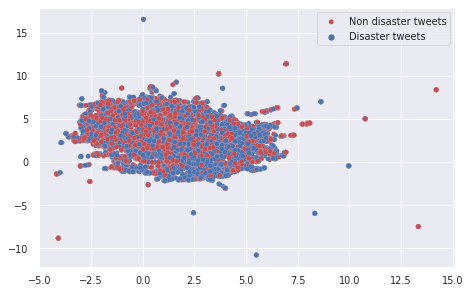

In [116]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(input_ids.numpy())
plot_sns(trans.embedding_,labels.numpy())